In [1]:
%load_ext autoreload
%autoreload 2

### Dataset

In [2]:
import numpy
import torch
import torchvision
import torchvision.transforms.v2

transform = torchvision.transforms.v2.Compose([
    torchvision.transforms.v2.ToImage(),
    torchvision.transforms.v2.ToDtype(torch.float32, scale = True)
])

train = torchvision.datasets.CIFAR10('cifar-10', transform = transform, train = True, download = False)
test = torchvision.datasets.CIFAR10('cifar-10', transform = transform, train = False, download = False)

train_images = numpy.array([ numpy.array(item[0]) for item in train ])
train_labels = numpy.array([ item[1] for item in train ])

test_images = numpy.array([ numpy.array(item[0]) for item in test ])
test_labels = numpy.array([ item[1] for item in test ])

train_images.shape, test_images.shape

((50000, 3, 32, 32), (10000, 3, 32, 32))

### Features

In [12]:
import os
import tqdm
import cvtda.utils
import cvtda.topology

def make_features(
    train: numpy.ndarray,
    test: numpy.ndarray,
    name: str,
    binarizer,
    filtration
):
    if os.path.exists(f"6/{name}/test_features.npy"):
        return
    
    if binarizer is not None:
        train = binarizer.fit_transform(train)
        test = binarizer.transform(test)
        
    if filtration is not None:
        train = filtration.fit_transform(train)
        test = filtration.transform(test)

    filtrations_to_diagrams = cvtda.topology.FiltrationsToDiagrams(homology_dimensions = [ 0, 1, 2 ])
    train = filtrations_to_diagrams.fit_transform(train)
    test = filtrations_to_diagrams.transform(test)
    print(train.shape, test.shape)

    n_bins = (64 if len(train) < 512 else 128)
    digrams_to_features = cvtda.topology.DiagramsToFeatures(batch_size = 625, n_bins = n_bins)
    train = digrams_to_features.fit_transform(train)
    test = digrams_to_features.transform(test)
    print(train.shape, test.shape)

    ok_features = []
    for idx in tqdm.trange(train.shape[1]):
        if numpy.std(train[:, idx]) > 1e-6:
            ok_features.append(idx)
    train = train[:, ok_features]
    test = test[:, ok_features]
    print(train.shape, test.shape)

    duplicates_remover = cvtda.utils.DuplicateFeaturesRemover()
    train = duplicates_remover.fit_transform(train)
    test = duplicates_remover.transform(test)
    print(train.shape, test.shape)

    os.makedirs(f"6/{name}", exist_ok = True)
    numpy.save(f"6/{name}/train_features.npy", train)
    numpy.save(f"6/{name}/test_features.npy", test)

In [ ]:
make_features(train_images, test_images, "raw", binarizer = None, filtration = None)

Fitting the persistence
Fitting complete
Calculating the persistence


100%|██████████| 50000/50000 [01:39<00:00, 501.99it/s]


Calculating the persistence


100%|██████████| 10000/10000 [00:20<00:00, 497.29it/s]


Fitting the calculator
Fitting the filtering
Fitting the betti curve
Fitting the persistence landscape


Fitting the silhouettes: 100%|██████████| 2/2 [00:03<00:00,  1.88s/it]


Fitting the persistence entropy
Fitting the number of points


Fitting the persistence images: 100%|██████████| 3/3 [00:06<00:00,  2.20s/it]


Fitting complete


Batch:   0%|          | 0/80 [00:00<?, ?it/s]d:\Programs\Programming\Python\lib\site-packages\joblib\externals\loky\process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
 48%|████▊     | 188/390 [00:00<00:00, 1861.45it/s]d:\Programs\Programming\Python\lib\site-packages\numpy\core\_methods.py:152: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)
d:\Programs\Programming\Python\lib\site-packages\numpy\core\_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
100%|██████████| 271/271 [00:00<00:00, 906.36it/s, partition_by=32105, num_features=2, duplicates=80]


Found 81 duplicates
Fitting the persistence
Fitting complete
Calculating the persistence


100%|██████████| 50000/50000 [02:06<00:00, 395.07it/s]


Calculating the persistence


100%|██████████| 10000/10000 [00:24<00:00, 402.72it/s]


Fitting the calculator
Fitting the filtering
Fitting the betti curve
Fitting the persistence landscape


Fitting the silhouettes: 100%|██████████| 2/2 [00:00<00:00,  2.18it/s]


Fitting the persistence entropy
Fitting the number of points


Fitting the persistence images: 100%|██████████| 3/3 [00:01<00:00,  1.90it/s]


Fitting complete


100%|██████████| 390/390 [00:00<00:00, 2252.62it/s]


In [13]:
import itertools
import gtda.images

greyscale_to_filtrations = cvtda.topology.GreyscaleToFiltrations(
    binarizer_threshold = 0.4,
    height_filtration_directions = list(itertools.product([ 0, 1, -1 ], [ 0, 1, -1 ], [ 0, 1, -1 ]))[1:],
    radial_filtration_centers = list(itertools.product([ 0, 1, 2 ], [ 3, 8, 13, 18, 23, 28 ], [ 3, 8, 13, 18, 23, 28 ]))
)
for i, filtration in enumerate(greyscale_to_filtrations.filtrations_):
    print(f"{i}/{len(greyscale_to_filtrations.filtrations_)}). {filtration}")
    make_features(
        train_images,
        test_images,
        f"{type(filtration).__name__}{i}",
        binarizer = gtda.images.Binarizer(threshold = 0.4),
        filtration = filtration
    )

0/139). HeightFiltration(direction=array([0, 0, 1]), n_jobs=-1)
1/139). HeightFiltration(direction=array([ 0,  0, -1]), n_jobs=-1)
2/139). HeightFiltration(direction=array([0, 1, 0]), n_jobs=-1)
3/139). HeightFiltration(direction=array([0, 1, 1]), n_jobs=-1)
4/139). HeightFiltration(direction=array([ 0,  1, -1]), n_jobs=-1)
Fitting the persistence
Fitting complete
Calculating the persistence


100%|██████████| 50000/50000 [01:50<00:00, 451.43it/s]


Calculating the persistence


100%|██████████| 10000/10000 [00:21<00:00, 459.33it/s]


(50000, 134, 3) (10000, 87, 3)
Fitting the calculator
Fitting the filtering
Fitting the betti curve
Fitting the persistence landscape


Fitting the silhouettes: 100%|██████████| 2/2 [00:00<00:00,  2.51it/s]


Fitting the persistence entropy
Fitting the number of points


Fitting the persistence images: 100%|██████████| 3/3 [00:01<00:00,  2.23it/s]


Fitting complete


d:\Programs\Programming\Python\lib\site-packages\joblib\externals\loky\process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
Batch:  42%|████▎     | 34/80 [01:26<01:57,  2.55s/it]


KeyboardInterrupt: 

### Analyze features

In [3]:
import os

train_features = numpy.hstack([
    numpy.load(f"6/{folder}/train_features.npy")
    for folder in os.listdir("6")
])

test_features = numpy.hstack([
    numpy.load(f"6/{folder}/test_features.npy")
    for folder in os.listdir("6")
])

train_features.shape, test_features.shape

((50000, 37609), (10000, 37609))

In [4]:
import tqdm

ok_features = []
for idx in tqdm.trange(train_features.shape[1]):
    if numpy.std(train_features[:, idx]) > 1e-6:
        ok_features.append(idx)

train_features = train_features[:, ok_features]
test_features = test_features[:, ok_features]

100%|██████████| 37609/37609 [00:07<00:00, 5109.15it/s] 


In [5]:
import sklearn.preprocessing

selected_standard_scaler = sklearn.preprocessing.StandardScaler()
train_features = selected_standard_scaler.fit_transform(numpy.nan_to_num(train_features, 0))
test_features = selected_standard_scaler.transform(numpy.nan_to_num(test_features, 0))

train_features.shape, test_features.shape

((50000, 37609), (10000, 37609))

### StandardScaler

In [7]:
import cvtda.classification

Fitting KNeighborsClassifier(n_jobs=-1, n_neighbors=50)
{'classifier': 'KNeighborsClassifier', 'Accuracy': 0.3151, 'TOP-2 Accuracy': 0.4985, 'TOP-3 Accuracy': 0.6238, 'TOP-4 Accuracy': 0.7212, 'TOP-5 Accuracy': 0.7922, 'TOP-6 Accuracy': 0.853, 'TOP-7 Accuracy': 0.9047, 'TOP-8 Accuracy': 0.9434, 'TOP-9 Accuracy': 0.9752, 'AUC-ROC': 0.7584488611111112, 'Precision': 0.30925905350142546, 'Recall': 0.3151, 'F1-score': 0.30326548508259366}
Fitting RandomForestClassifier(n_jobs=-1, random_state=42)
{'classifier': 'RandomForestClassifier', 'Accuracy': 0.4098, 'TOP-2 Accuracy': 0.6022, 'TOP-3 Accuracy': 0.7171, 'TOP-4 Accuracy': 0.7965, 'TOP-5 Accuracy': 0.853, 'TOP-6 Accuracy': 0.9004, 'TOP-7 Accuracy': 0.9373, 'TOP-8 Accuracy': 0.9656, 'TOP-9 Accuracy': 0.9857, 'AUC-ROC': 0.8194695055555554, 'Precision': 0.4039506180383813, 'Recall': 0.4098, 'F1-score': 0.40457638138879853}
Fitting <cvtda.classification.nn_classifier.NNClassifier object at 0x00000229E6B76200>
Input to LazyLinear: 37609
Parame

100%|██████████| 25/25 [08:25<00:00, 20.23s/it, loss=9.92e+4, val_acc=0.479]


{'classifier': 'NNClassifier', 'Accuracy': 0.4792, 'TOP-2 Accuracy': 0.6695, 'TOP-3 Accuracy': 0.7759, 'TOP-4 Accuracy': 0.8418, 'TOP-5 Accuracy': 0.8894, 'TOP-6 Accuracy': 0.9248, 'TOP-7 Accuracy': 0.951, 'TOP-8 Accuracy': 0.9732, 'TOP-9 Accuracy': 0.9878, 'AUC-ROC': 0.84446015, 'Precision': 0.47495216498947, 'Recall': 0.47919999999999996, 'F1-score': 0.4756501072503826}
Fitting HistGradientBoostingClassifier(max_depth=4, max_features=0.1, max_iter=20,
                               random_state=42)


MemoryError: Unable to allocate 12.6 GiB for an array with shape (45000, 37609) and data type float64

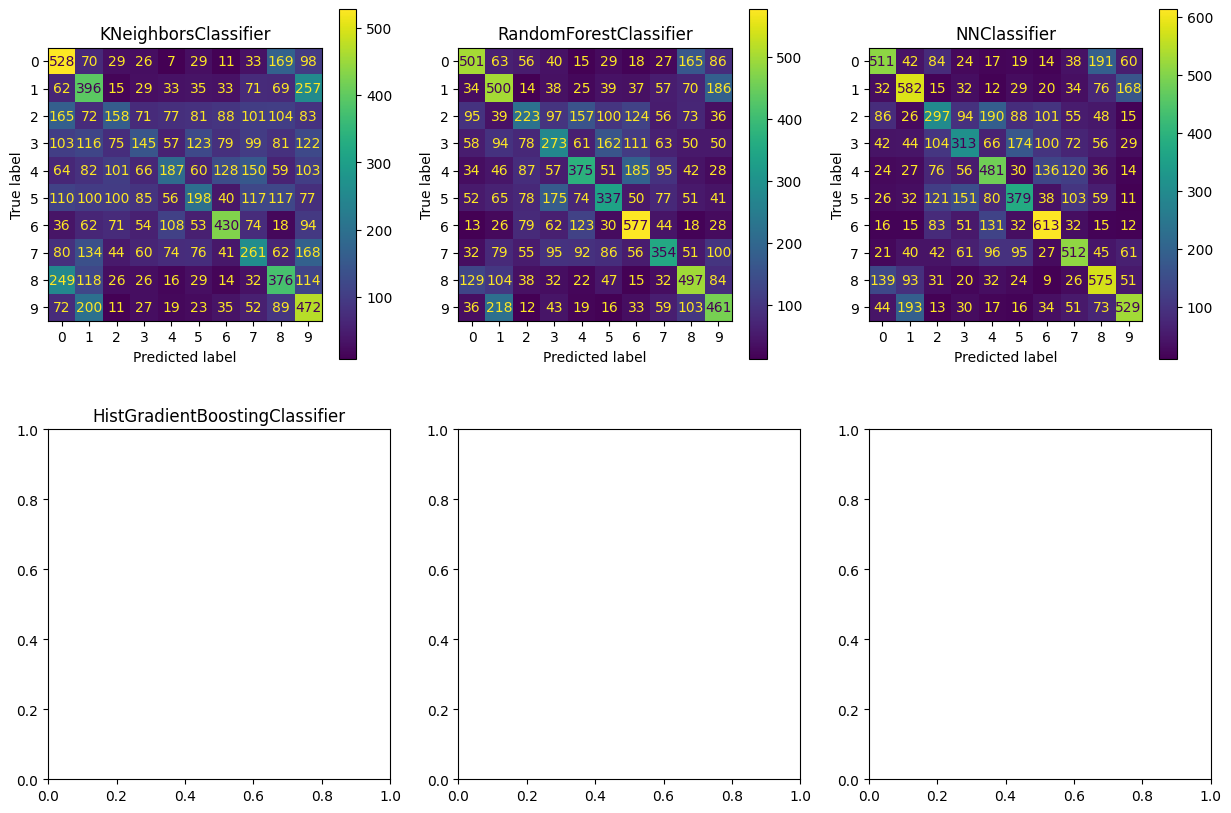

In [8]:
cvtda.classification.classify(
    train_features, train_labels, test_features, test_labels
)

### InformationValueFeatureSelector

Fitting the information value feature selector


information values: 100%|██████████| 37609/37609 [06:02<00:00, 103.63it/s]


Fitting complete


((50000, 17337), (10000, 17337))

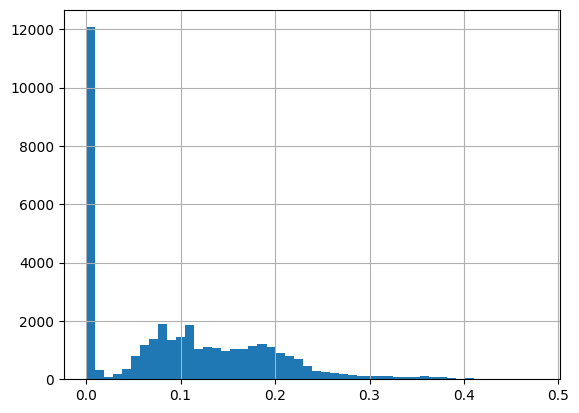

In [6]:
import cvtda.classification

feature_selector = cvtda.classification.InformationValueFeatureSelector(threshold = 0.1, bins = 50)

train_features = feature_selector.fit_transform(train_features, train_labels)
test_features = feature_selector.transform(test_features)

feature_selector.hist()

train_features.shape, test_features.shape

Fitting KNeighborsClassifier(n_jobs=-1, n_neighbors=50)
{'classifier': 'KNeighborsClassifier', 'Accuracy': 0.3374, 'TOP-2 Accuracy': 0.5192, 'TOP-3 Accuracy': 0.6481, 'TOP-4 Accuracy': 0.7409, 'TOP-5 Accuracy': 0.8147, 'TOP-6 Accuracy': 0.8706, 'TOP-7 Accuracy': 0.9168, 'TOP-8 Accuracy': 0.9545, 'TOP-9 Accuracy': 0.9835, 'AUC-ROC': 0.7749163777777777, 'Precision': 0.3340054149003535, 'Recall': 0.3374, 'F1-score': 0.3269199631904173}
Fitting RandomForestClassifier(n_jobs=-1, random_state=42)
{'classifier': 'RandomForestClassifier', 'Accuracy': 0.4116, 'TOP-2 Accuracy': 0.6094, 'TOP-3 Accuracy': 0.723, 'TOP-4 Accuracy': 0.7998, 'TOP-5 Accuracy': 0.8577, 'TOP-6 Accuracy': 0.8994, 'TOP-7 Accuracy': 0.9348, 'TOP-8 Accuracy': 0.9647, 'TOP-9 Accuracy': 0.9855, 'AUC-ROC': 0.8198308944444441, 'Precision': 0.40589396012767, 'Recall': 0.41159999999999997, 'F1-score': 0.4065797945647712}
Fitting <cvtda.classification.nn_classifier.NNClassifier object at 0x000001B47E9B2EF0>
Input to LazyLinear: 173

100%|██████████| 25/25 [05:20<00:00, 12.82s/it, loss=9.97e+4, val_acc=0.476]


{'classifier': 'NNClassifier', 'Accuracy': 0.4757, 'TOP-2 Accuracy': 0.6732, 'TOP-3 Accuracy': 0.7783, 'TOP-4 Accuracy': 0.8448, 'TOP-5 Accuracy': 0.8927, 'TOP-6 Accuracy': 0.9282, 'TOP-7 Accuracy': 0.9551, 'TOP-8 Accuracy': 0.9753, 'TOP-9 Accuracy': 0.9896, 'AUC-ROC': 0.8449997277777778, 'Precision': 0.4708360430045671, 'Recall': 0.47569999999999996, 'F1-score': 0.4711548087757588}
Fitting HistGradientBoostingClassifier(max_depth=4, max_features=0.1, max_iter=20,
                               random_state=42)
{'classifier': 'HistGradientBoostingClassifier', 'Accuracy': 0.4187, 'TOP-2 Accuracy': 0.6242, 'TOP-3 Accuracy': 0.7445, 'TOP-4 Accuracy': 0.8243, 'TOP-5 Accuracy': 0.883, 'TOP-6 Accuracy': 0.925, 'TOP-7 Accuracy': 0.9551, 'TOP-8 Accuracy': 0.975, 'TOP-9 Accuracy': 0.9902, 'AUC-ROC': 0.8378860999999999, 'Precision': 0.41282457060236427, 'Recall': 0.4187, 'F1-score': 0.41293064667405277}
Fitting XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_

d:\Programs\Programming\Python\lib\site-packages\xgboost\core.py:158: UserWarning: [21:00:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


{'classifier': 'XGBClassifier', 'Accuracy': 0.45, 'TOP-2 Accuracy': 0.6541, 'TOP-3 Accuracy': 0.7711, 'TOP-4 Accuracy': 0.8445, 'TOP-5 Accuracy': 0.8959, 'TOP-6 Accuracy': 0.9332, 'TOP-7 Accuracy': 0.9603, 'TOP-8 Accuracy': 0.9786, 'TOP-9 Accuracy': 0.9922, 'AUC-ROC': 0.8552496888888892, 'Precision': 0.44412503150195287, 'Recall': 0.45, 'F1-score': 0.44540766012635863}


,classifier,Accuracy,TOP-2 Accuracy,TOP-3 Accuracy,TOP-4 Accuracy,TOP-5 Accuracy,TOP-6 Accuracy,TOP-7 Accuracy,TOP-8 Accuracy,TOP-9 Accuracy,AUC-ROC,Precision,Recall,F1-score
0,KNeighborsClassifier,0.3374,0.5192,0.6481,0.7409,0.8147,0.8706,0.9168,0.9545,0.9835,0.774916,0.334005,0.3374,0.326920
1,RandomForestClassifier,0.4116,0.6094,0.7230,0.7998,0.8577,0.8994,0.9348,0.9647,0.9855,0.819831,0.405894,0.4116,0.406580
2,NNClassifier,0.4757,0.6732,0.7783,0.8448,0.8927,0.9282,0.9551,0.9753,0.9896,0.845000,0.470836,0.4757,0.471155
3,HistGradientBoostingClassifier,0.4187,0.6242,0.7445,0.8243,0.8830,0.9250,0.9551,0.9750,0.9902,0.837886,0.412825,0.4187,0.412931
4,XGBClassifier,0.4500,0.6541,0.7711,0.8445,0.8959,0.9332,0.9603,0.9786,0.9922,0.855250,0.444125,0.4500,0.445408


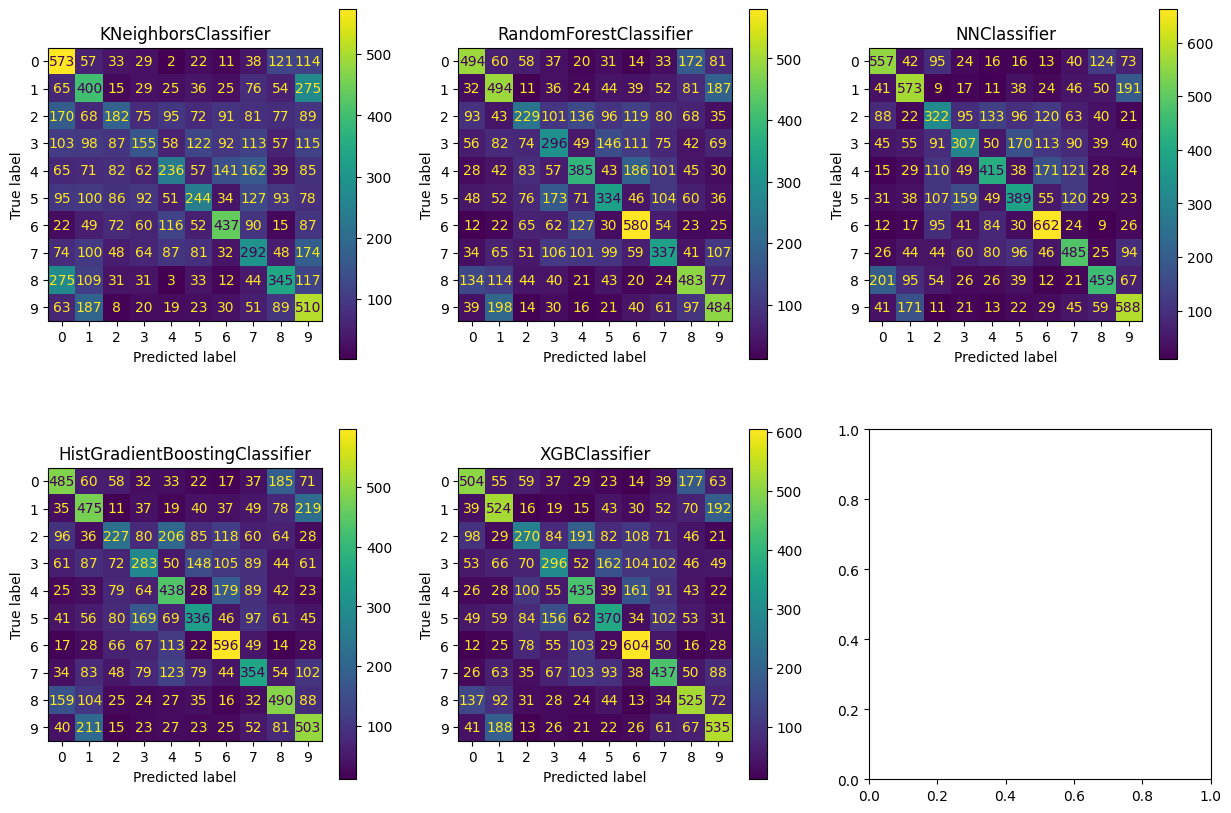

In [7]:
cvtda.classification.classify(
    train_features, train_labels, test_features, test_labels
)

Fitting <catboost.core.CatBoostClassifier object at 0x000001B567FD96C0>
Learning rate set to 0.309284
0:	learn: 2.1551183	total: 772ms	remaining: 5m 8s
1:	learn: 2.0691173	total: 1.3s	remaining: 4m 18s
2:	learn: 2.0037489	total: 1.84s	remaining: 4m 3s
3:	learn: 1.9583920	total: 2.33s	remaining: 3m 50s
4:	learn: 1.9179059	total: 2.88s	remaining: 3m 47s
5:	learn: 1.8911572	total: 3.4s	remaining: 3m 43s
6:	learn: 1.8659752	total: 3.92s	remaining: 3m 40s
7:	learn: 1.8439331	total: 4.45s	remaining: 3m 38s
8:	learn: 1.8226083	total: 5s	remaining: 3m 37s
9:	learn: 1.8046898	total: 5.55s	remaining: 3m 36s
10:	learn: 1.7869111	total: 6.1s	remaining: 3m 35s
11:	learn: 1.7711636	total: 6.66s	remaining: 3m 35s
12:	learn: 1.7586984	total: 7.21s	remaining: 3m 34s
13:	learn: 1.7486127	total: 7.64s	remaining: 3m 30s
14:	learn: 1.7368466	total: 8.16s	remaining: 3m 29s
15:	learn: 1.7258319	total: 8.67s	remaining: 3m 28s
16:	learn: 1.7149484	total: 9.19s	remaining: 3m 27s
17:	learn: 1.7051503	total: 9.69

,classifier,Accuracy,TOP-2 Accuracy,TOP-3 Accuracy,TOP-4 Accuracy,TOP-5 Accuracy,TOP-6 Accuracy,TOP-7 Accuracy,TOP-8 Accuracy,TOP-9 Accuracy,AUC-ROC,Precision,Recall,F1-score
0,CatBoostClassifier,0.5002,0.7046,0.8117,0.8791,0.9215,0.9521,0.9737,0.9862,0.9957,0.882901,0.495499,0.5002,0.497231


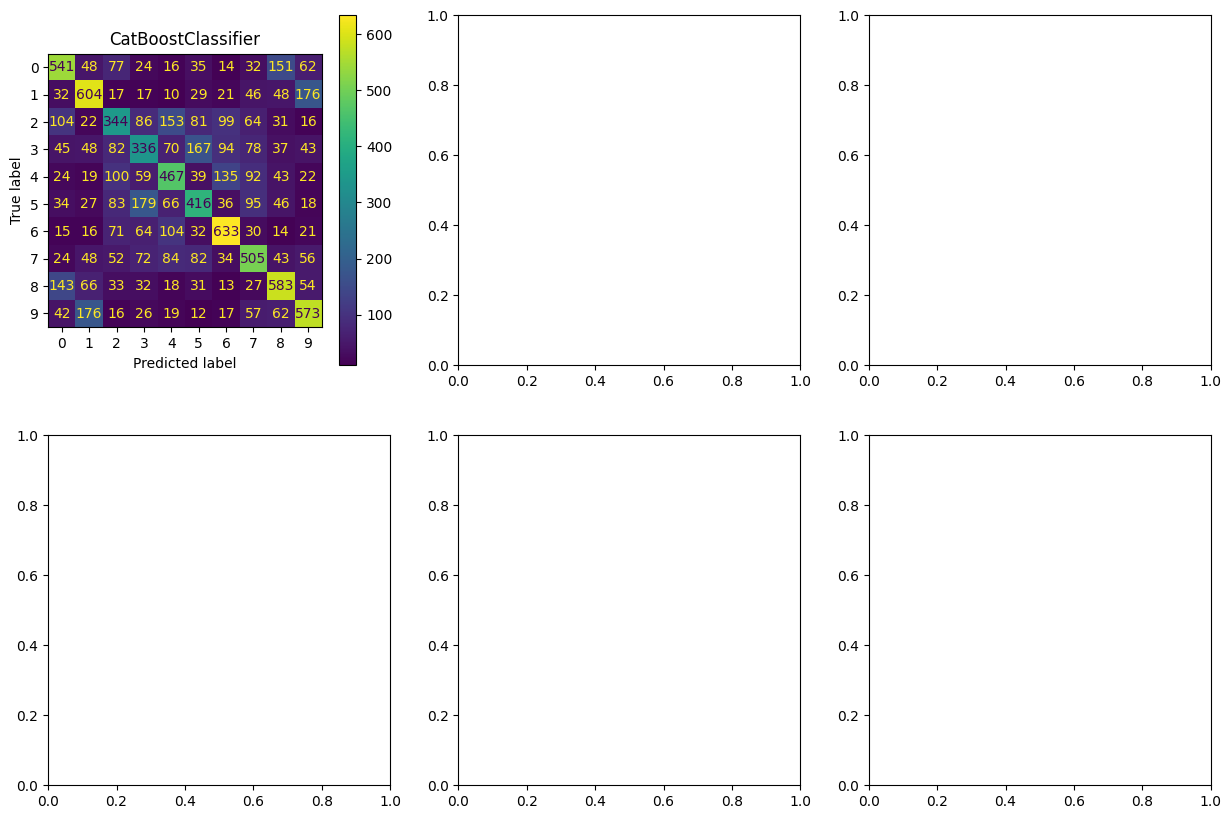

In [8]:
cvtda.classification.classify(
    train_features, train_labels, test_features, test_labels
)

### CorrelationSelector

Fitting the correlations feature selector
Fitting complete


((50000, 12043), (10000, 12043))

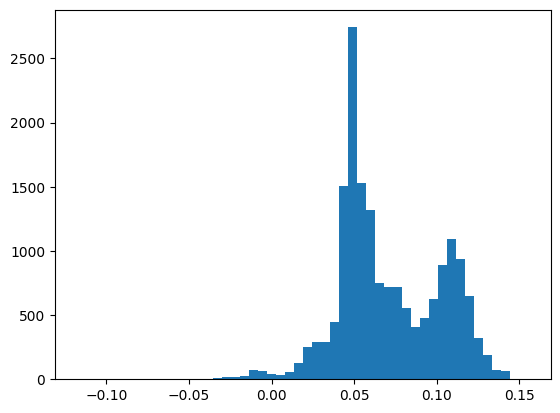

In [9]:
correlation_selector = cvtda.classification.CorrelationSelector(threshold = 0.05)

train_features = correlation_selector.fit_transform(train_features, train_labels)
test_features = correlation_selector.transform(test_features)

correlation_selector.hist()

train_features.shape, test_features.shape

Fitting KNeighborsClassifier(n_jobs=-1, n_neighbors=50)
{'classifier': 'KNeighborsClassifier', 'Accuracy': 0.3288, 'TOP-2 Accuracy': 0.5145, 'TOP-3 Accuracy': 0.6365, 'TOP-4 Accuracy': 0.7307, 'TOP-5 Accuracy': 0.8068, 'TOP-6 Accuracy': 0.8673, 'TOP-7 Accuracy': 0.9106, 'TOP-8 Accuracy': 0.9479, 'TOP-9 Accuracy': 0.9775, 'AUC-ROC': 0.7670170555555554, 'Precision': 0.32063200433750455, 'Recall': 0.32880000000000004, 'F1-score': 0.31588302816117464}
Fitting RandomForestClassifier(n_jobs=-1, random_state=42)
{'classifier': 'RandomForestClassifier', 'Accuracy': 0.4024, 'TOP-2 Accuracy': 0.5934, 'TOP-3 Accuracy': 0.7083, 'TOP-4 Accuracy': 0.7867, 'TOP-5 Accuracy': 0.8494, 'TOP-6 Accuracy': 0.8956, 'TOP-7 Accuracy': 0.9331, 'TOP-8 Accuracy': 0.964, 'TOP-9 Accuracy': 0.9851, 'AUC-ROC': 0.8121601388888888, 'Precision': 0.39394779740855895, 'Recall': 0.4023999999999999, 'F1-score': 0.39543261416225406}
Fitting <cvtda.classification.nn_classifier.NNClassifier object at 0x000001B4B4D83D90>
Input 

100%|██████████| 25/25 [03:46<00:00,  9.05s/it, loss=1.01e+5, val_acc=0.461]


{'classifier': 'NNClassifier', 'Accuracy': 0.4609, 'TOP-2 Accuracy': 0.655, 'TOP-3 Accuracy': 0.7673, 'TOP-4 Accuracy': 0.8344, 'TOP-5 Accuracy': 0.8877, 'TOP-6 Accuracy': 0.9255, 'TOP-7 Accuracy': 0.9522, 'TOP-8 Accuracy': 0.9719, 'TOP-9 Accuracy': 0.9884, 'AUC-ROC': 0.8367554666666667, 'Precision': 0.4548005193742478, 'Recall': 0.4609, 'F1-score': 0.4549896539716591}
Fitting HistGradientBoostingClassifier(max_depth=4, max_features=0.1, max_iter=20,
                               random_state=42)
{'classifier': 'HistGradientBoostingClassifier', 'Accuracy': 0.4072, 'TOP-2 Accuracy': 0.6075, 'TOP-3 Accuracy': 0.7296, 'TOP-4 Accuracy': 0.8092, 'TOP-5 Accuracy': 0.8659, 'TOP-6 Accuracy': 0.9157, 'TOP-7 Accuracy': 0.9491, 'TOP-8 Accuracy': 0.9732, 'TOP-9 Accuracy': 0.9894, 'AUC-ROC': 0.826706911111111, 'Precision': 0.3982622204224329, 'Recall': 0.4072, 'F1-score': 0.3991744941592245}
Fitting <catboost.core.CatBoostClassifier object at 0x000001B4B4DF20B0>
Learning rate set to 0.309284
0:	le

,classifier,Accuracy,TOP-2 Accuracy,TOP-3 Accuracy,TOP-4 Accuracy,TOP-5 Accuracy,TOP-6 Accuracy,TOP-7 Accuracy,TOP-8 Accuracy,TOP-9 Accuracy,AUC-ROC,Precision,Recall,F1-score
0,KNeighborsClassifier,0.3288,0.5145,0.6365,0.7307,0.8068,0.8673,0.9106,0.9479,0.9775,0.767017,0.320632,0.3288,0.315883
1,RandomForestClassifier,0.4024,0.5934,0.7083,0.7867,0.8494,0.8956,0.9331,0.9640,0.9851,0.812160,0.393948,0.4024,0.395433
2,NNClassifier,0.4609,0.6550,0.7673,0.8344,0.8877,0.9255,0.9522,0.9719,0.9884,0.836755,0.454801,0.4609,0.454990
3,HistGradientBoostingClassifier,0.4072,0.6075,0.7296,0.8092,0.8659,0.9157,0.9491,0.9732,0.9894,0.826707,0.398262,0.4072,0.399174
4,CatBoostClassifier,0.4861,0.6889,0.7985,0.8711,0.9170,0.9493,0.9706,0.9859,0.9954,0.876073,0.481186,0.4861,0.482941
5,XGBClassifier,0.4293,0.6406,0.7565,0.8310,0.8874,0.9282,0.9584,0.9795,0.9938,0.846434,0.422311,0.4293,0.423768


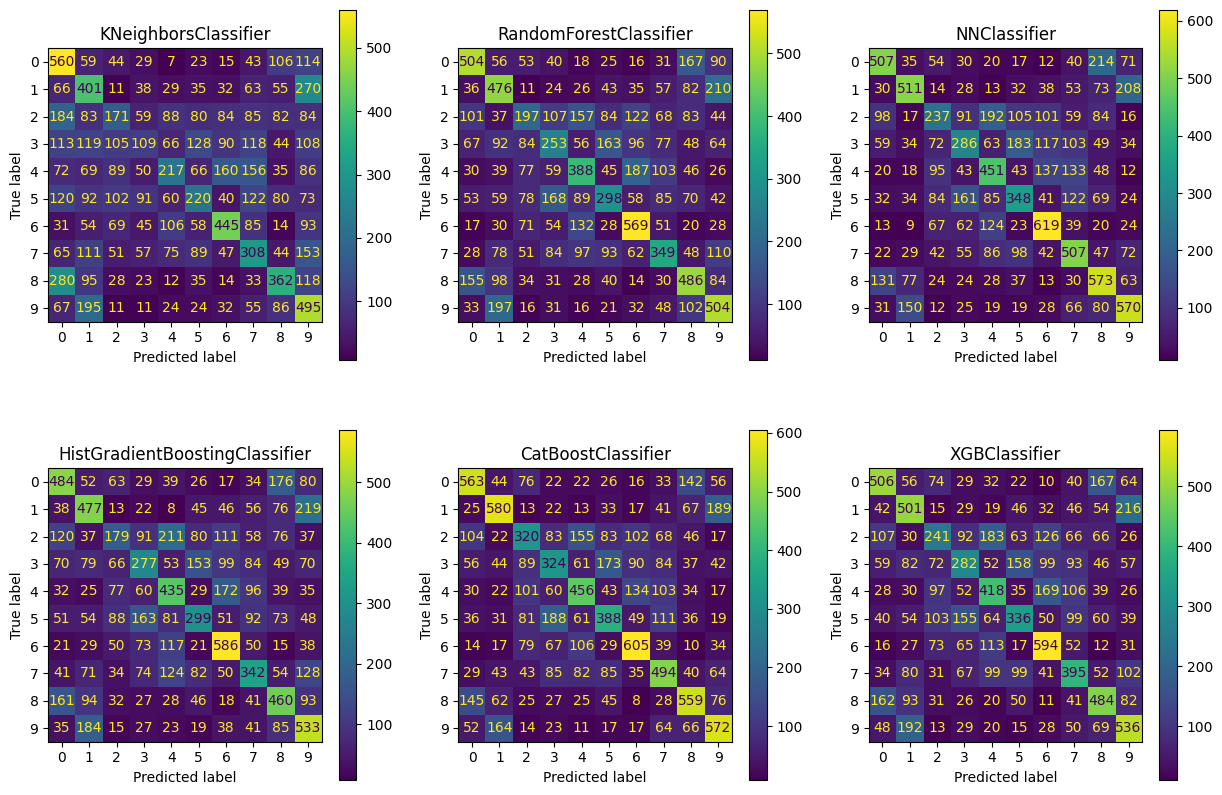

In [10]:
cvtda.classification.classify(
    train_features, train_labels, test_features, test_labels
)

### PCA

In [11]:
import sklearn.decomposition

pca = sklearn.decomposition.PCA(n_components = 64, random_state = 42)

train_features = pca.fit_transform(train_features)
print('Explained variance', round(pca.explained_variance_ratio_.sum(), 2))
print([ round(x, 3) for x in pca.explained_variance_ratio_ ])

test_features = pca.transform(test_features)

train_features.shape, test_features.shape

Explained variance 0.96
[0.537, 0.172, 0.06, 0.034, 0.024, 0.014, 0.011, 0.01, 0.009, 0.008, 0.008, 0.005, 0.004, 0.004, 0.004, 0.003, 0.003, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


((50000, 64), (10000, 64))

Fitting KNeighborsClassifier(n_jobs=-1, n_neighbors=50)
{'classifier': 'KNeighborsClassifier', 'Accuracy': 0.3262, 'TOP-2 Accuracy': 0.5096, 'TOP-3 Accuracy': 0.6348, 'TOP-4 Accuracy': 0.7297, 'TOP-5 Accuracy': 0.8045, 'TOP-6 Accuracy': 0.8656, 'TOP-7 Accuracy': 0.9135, 'TOP-8 Accuracy': 0.949, 'TOP-9 Accuracy': 0.9788, 'AUC-ROC': 0.7650762444444446, 'Precision': 0.3198359934372534, 'Recall': 0.3262, 'F1-score': 0.31649257116791407}
Fitting RandomForestClassifier(n_jobs=-1, random_state=42)
{'classifier': 'RandomForestClassifier', 'Accuracy': 0.3731, 'TOP-2 Accuracy': 0.5635, 'TOP-3 Accuracy': 0.6818, 'TOP-4 Accuracy': 0.7684, 'TOP-5 Accuracy': 0.8371, 'TOP-6 Accuracy': 0.888, 'TOP-7 Accuracy': 0.9264, 'TOP-8 Accuracy': 0.9576, 'TOP-9 Accuracy': 0.9821, 'AUC-ROC': 0.7939755500000001, 'Precision': 0.36639525199002043, 'Recall': 0.3731, 'F1-score': 0.3676549993848929}
Fitting <cvtda.classification.nn_classifier.NNClassifier object at 0x000001B4B4D83D60>
Input to LazyLinear: 64
Parameters

100%|██████████| 25/25 [00:33<00:00,  1.33s/it, loss=1.07e+5, val_acc=0.379]


{'classifier': 'NNClassifier', 'Accuracy': 0.3786, 'TOP-2 Accuracy': 0.5657, 'TOP-3 Accuracy': 0.6871, 'TOP-4 Accuracy': 0.7724, 'TOP-5 Accuracy': 0.8395, 'TOP-6 Accuracy': 0.8882, 'TOP-7 Accuracy': 0.9239, 'TOP-8 Accuracy': 0.9579, 'TOP-9 Accuracy': 0.9803, 'AUC-ROC': 0.7896528777777776, 'Precision': 0.37573460961312605, 'Recall': 0.3786, 'F1-score': 0.3676921607071688}
Fitting HistGradientBoostingClassifier(max_depth=4, max_features=0.1, max_iter=20,
                               random_state=42)
{'classifier': 'HistGradientBoostingClassifier', 'Accuracy': 0.3534, 'TOP-2 Accuracy': 0.5438, 'TOP-3 Accuracy': 0.6674, 'TOP-4 Accuracy': 0.7607, 'TOP-5 Accuracy': 0.8323, 'TOP-6 Accuracy': 0.8862, 'TOP-7 Accuracy': 0.927, 'TOP-8 Accuracy': 0.9607, 'TOP-9 Accuracy': 0.9847, 'AUC-ROC': 0.7854389444444446, 'Precision': 0.3436209320963311, 'Recall': 0.35340000000000005, 'F1-score': 0.3441174685046729}
Fitting <catboost.core.CatBoostClassifier object at 0x000001B5679C69B0>
Learning rate set to

,classifier,Accuracy,TOP-2 Accuracy,TOP-3 Accuracy,TOP-4 Accuracy,TOP-5 Accuracy,TOP-6 Accuracy,TOP-7 Accuracy,TOP-8 Accuracy,TOP-9 Accuracy,AUC-ROC,Precision,Recall,F1-score
0,KNeighborsClassifier,0.3262,0.5096,0.6348,0.7297,0.8045,0.8656,0.9135,0.9490,0.9788,0.765076,0.319836,0.3262,0.316493
1,RandomForestClassifier,0.3731,0.5635,0.6818,0.7684,0.8371,0.8880,0.9264,0.9576,0.9821,0.793976,0.366395,0.3731,0.367655
2,NNClassifier,0.3786,0.5657,0.6871,0.7724,0.8395,0.8882,0.9239,0.9579,0.9803,0.789653,0.375735,0.3786,0.367692
3,HistGradientBoostingClassifier,0.3534,0.5438,0.6674,0.7607,0.8323,0.8862,0.9270,0.9607,0.9847,0.785439,0.343621,0.3534,0.344117
4,CatBoostClassifier,0.4096,0.6114,0.7298,0.8099,0.8756,0.9209,0.9547,0.9762,0.9917,0.830085,0.404274,0.4096,0.406221
5,XGBClassifier,0.3660,0.5709,0.6913,0.7794,0.8475,0.8999,0.9369,0.9685,0.9869,0.803312,0.360220,0.3660,0.360715


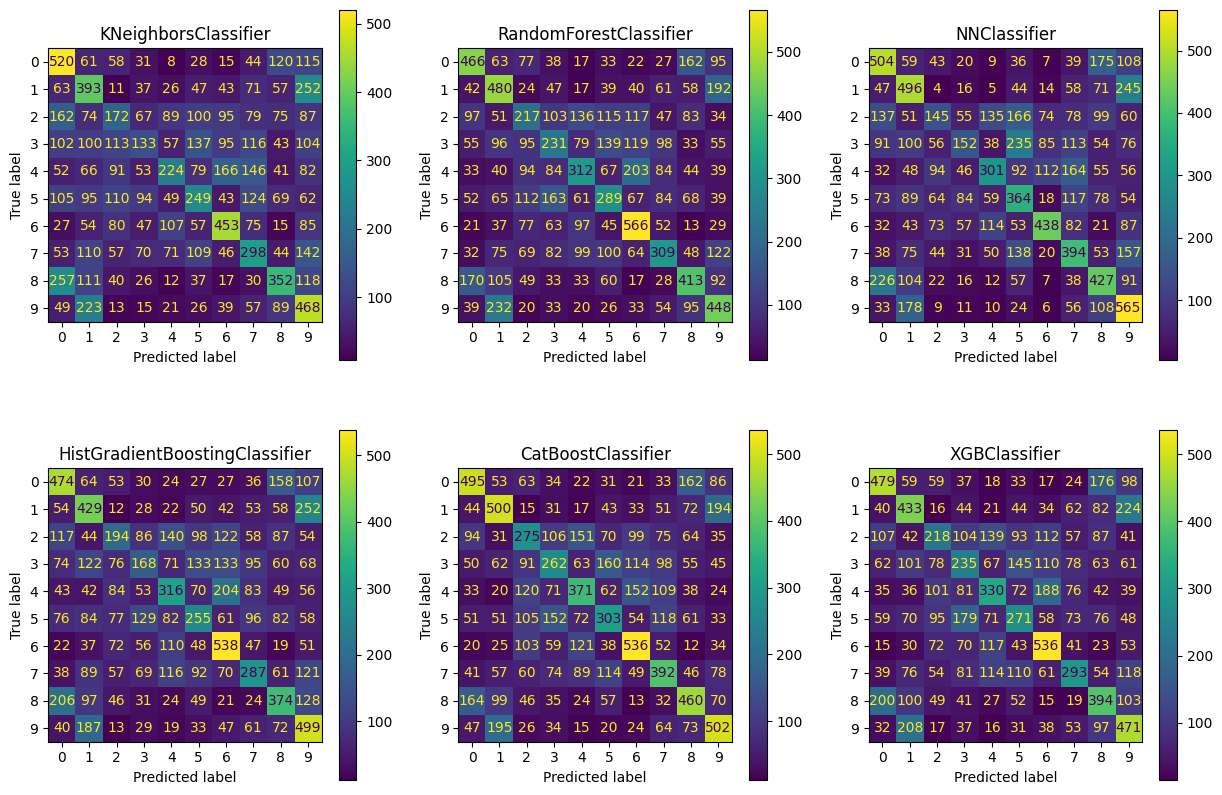

In [12]:
cvtda.classification.classify(
    train_features, train_labels, test_features, test_labels
)